In [91]:
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import AnyMessage
import operator

class AgentState(TypedDict):
    messages: Annotated[Sequence[AnyMessage], operator.add]

In [92]:
def fun1(state: AgentState):
    return {
        "messages": ["Hello World! from function 1"]
    }

In [93]:
def fun2(state: AgentState):
    return {
        "messages": ["Hello World! from function 2"]
    }

In [94]:
from langgraph.graph import START, END, StateGraph
workflow = StateGraph(AgentState)
workflow.add_node("fun1", fun1)
workflow.add_node("fun2", fun2)
workflow.add_edge("fun1", "fun2")
workflow.set_entry_point("fun1")
workflow.set_finish_point("fun2")
app = workflow.compile()

In [95]:
response = app.invoke({"messages": ["Hi hello How are you?"]})

In [96]:
response

{'messages': ['Hi hello How are you?',
  'Hello World! from function 1',
  'Hello World! from function 2']}

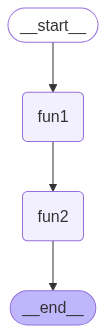

In [97]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [98]:
for output in app.stream({"messages": ["Hi hello How are you?"]}):
    for key, value in output.items():
        print(f"Here is output from {key}")
        print("________________________________")
        print(value)
        print('\n')

Here is output from fun1
________________________________
{'messages': ['Hello World! from function 1']}


Here is output from fun2
________________________________
{'messages': ['Hello World! from function 2']}




In [99]:
from typing import TypedDict, Annotated
import operator

class MessageState(TypedDict):
    messages: Annotated[str, operator.add]

In [100]:
def fun1(state: MessageState):
    return {
        "messages": " | Hello World from Function 1"
    }

In [101]:
def fun2(state: MessageState):
    return {
        "messages": " | Hello World from Function 2"
    }

In [102]:
workflow = StateGraph(MessageState)
workflow.add_node("fun1", fun1)
workflow.add_node("fun2", fun2)
workflow.add_edge("fun1", "fun2")
workflow.set_entry_point("fun1")
workflow.set_finish_point("fun2")
app = workflow.compile()

In [109]:
app.invoke({"messages": "Hi I am suriyaa"})

{'messages': 'Hi I am suriyaa | Hello World from Function 1 | Hello World from Function 2'}

In [108]:
for output in app.stream({"messages": "Hello World I am Suriyaa! "}):
    for key,value in output.items():
        print(key)
        print('__________')
        print(value)
        print('\n')

fun1
__________
{'messages': ' | Hello World from Function 1'}


fun2
__________
{'messages': ' | Hello World from Function 2'}




### Output Token Counter Project

In [184]:
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
import operator
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [185]:
def llm(state: AgentState):
    from langchain_google_genai import ChatGoogleGenerativeAI
    from langchain_core.messages import AIMessage
    
    import os
    os.environ['GOOGLE_API_KEY'] = os.getenv('GOOGLE_API_KEY')
    llm = ChatGoogleGenerativeAI(
        model = 'gemini-1.5-flash'
    )
    question = state['messages']
    answer = llm.invoke(question)
    return {
        "messages": [answer]
    }
    

In [ ]:
def llm_output_token_counter(state: AgentState)->str:
    from langchain_core.messages import HumanMessage
    ai_answer = state['messages'][-1]
    no_of_output_tokens = ai_answer.usage_metadata['output_tokens']
    return {
        "messages": [HumanMessage(content=f"Total output tokens required to generate the output is {no_of_output_tokens}")]
    }

In [192]:
workflow = StateGraph(AgentState)
workflow.add_node("LLM", llm)
workflow.add_node("LLM Output Token Counter", llm_output_token_counter)
workflow.set_entry_point("LLM")
workflow.set_finish_point("LLM Output Token Counter")
workflow.add_edge("LLM", "LLM Output Token Counter")
app = workflow.compile()

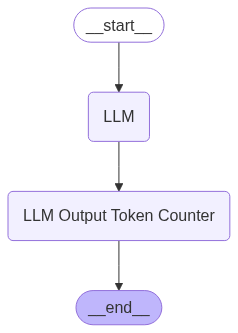

In [193]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [202]:
from langchain_core.messages import HumanMessage
response = app.invoke({
    "messages": [HumanMessage(content="What is the capital of India and could you explain about it")]
})
response['messages'][-1].content

content='The capital of India is **New Delhi**.  It\'s not just a single city, but rather a city within a city.  To understand it properly, you need to differentiate between Delhi and New Delhi:\n\n* **Delhi:** This is a much larger historical region, encompassing a vast area and a long, rich history.  It\'s been a capital city for numerous empires and kingdoms over centuries, leaving behind a diverse architectural and cultural legacy.  Within Delhi, you\'ll find areas like Old Delhi (Shahjahnabad), known for its bustling markets, Mughal-era architecture, and narrow lanes; and New Delhi, a more planned and modern area.\n\n* **New Delhi:** This is the planned city built by the British during the early 20th century as the capital of British India. It\'s characterized by wide avenues, grand colonial architecture (like Rashtrapati Bhavan – the President\'s House, and India Gate), and well-organized administrative structures.  New Delhi is the seat of the Indian government, housing Parliame

'Total output tokens required to generate the output is 325'

In [203]:
for output in app.stream({ "messages": [HumanMessage(content="What is the capital of India and could you explain about it")]}):
    for key, value in output.items():
        print(f"Output for the following question {key}")
        print("___________________")
        print(f"{value}")

Output for the following question LLM
___________________
{'messages': [AIMessage(content='The capital of India is **New Delhi**.  It\'s not just a single city, but rather a city *within* a larger city – Delhi.  To understand it, you need to grasp the distinction:\n\n* **Delhi:**  This is a historical region and a larger administrative territory encompassing several cities and towns.  It has a long and rich history, dating back thousands of years, and has served as a capital under various empires and dynasties.\n\n* **New Delhi:** This is a planned city built within the larger Delhi territory during the British Raj (British rule in India).  It became the capital of British India in 1911, and after India\'s independence in 1947, it continued as the capital of the Republic of India.  New Delhi is more modern in its planning and architecture compared to the older parts of Delhi.\n\nSo, while people often use "Delhi" and "New Delhi" interchangeably,  New Delhi specifically refers to the pl